In [9]:
from collections import defaultdict, Counter
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sn
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
main_df_sampled = pd.read_pickle('main_df_sampled.pickle')
main_df_sampled

,id,subreddit,title,selftext,genre
0,4ra2z6,Throwers,new to this (vibrations),"""i recently got back into yoyos last time i ha...",hobby
1,6dkhwl,weddingplanning,vendor and photographer issues and frustrations,"""your stories and advice are most certainly we...",sex/relationships
2,5jzfbj,redditdev,[praw 360] test if comment is top level ? or ...,"""i mod a sub that is looking into adding a rul...",meta
3,6680x8,csshelp,in /r/modern_hp_theme (a test subreddit) how c...,"""/r/modern_hp_theme space:nowrap;color:#666...",programming
4,4tadox,StrangerThings,mr wheeler stole every scene he was in,"""""""what did i do ? what did iiiiiiiii doooooo...",tv_show
...,...,...,...,...,...
116995,6cum56,LearnJapanese,i'm having trouble reading the number 七十一万四千 w...,what throws me off is the 七十一 at the beginning...,education
116996,6dud8e,HotPeppers,my reaper seeds won't sprout,i'm using the damp towel in plastic bag method...,food/drink
116997,4nyacs,Warmachine,what happened to skorne ?,"""so i have no idea what happened to other fact...",board_game
116998,66y8wp,TalesFromThePizzaGuy,"""""""ma'am i know you're lying right now enjoy y...","""last week we were stupid slow all day and thi...",writing/stories


In [11]:
genres = sorted(main_df_sampled['genre'].unique().tolist()) # this has to be sorted to match up with lstm model

print('Number of genres:', len(genres))

Number of genres: 39


In [12]:
# Get frequencies of each subreddit using efficient pandas filtering.
frequencies = defaultdict(int)
for genre in genres:
    frequencies[genre] = len(main_df_sampled.loc[main_df_sampled['genre'] == genre])

frequencies_df = pd.DataFrame([frequencies])
frequencies_df = frequencies_df.T

print(scipy.stats.describe(list(frequencies.values())))
print(frequencies_df)

DescribeResult(nobs=39, minmax=(3000, 3000), mean=3000.0, variance=0.0, skewness=nan, kurtosis=nan)
                          0
advice/question        3000
animals                3000
anime/manga            3000
appearance             3000
arts                   3000
autos                  3000
board_game             3000
books                  3000
card_game              3000
company/website        3000
crypto                 3000
drugs                  3000
education              3000
electronics            3000
finance/money          3000
food/drink             3000
geo                    3000
hardware/tools         3000
health                 3000
hobby                  3000
meta                   3000
movies                 3000
music                  3000
other                  3000
parenting              3000
politics/viewpoint     3000
profession             3000
programming            3000
religion/supernatural  3000
rpg                    3000
sex/relationships      3000
soci

C:\Users\Checkout\AppData\Local\Temp\ipykernel_7476\991558748.py:9: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  print(scipy.stats.describe(list(frequencies.values())))
C:\Users\Checkout\venv\Lib\site-packages\scipy\stats\_stats_py.py:1383: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
C:\Users\Checkout\venv\Lib\site-packages\scipy\stats\_stats_py.py:1384: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)


In [13]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Checkout\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim.utils import simple_preprocess
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm

vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = vectorizer.fit_transform(main_df_sampled['title'] + " " + main_df_sampled['selftext'])

In [16]:
from sklearn.preprocessing import LabelEncoder

y = main_df_sampled['genre'].copy()

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

genre_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Genre Mapping:")
print(genre_mapping)

Genre Mapping:
{'advice/question': 0, 'animals': 1, 'anime/manga': 2, 'appearance': 3, 'arts': 4, 'autos': 5, 'board_game': 6, 'books': 7, 'card_game': 8, 'company/website': 9, 'crypto': 10, 'drugs': 11, 'education': 12, 'electronics': 13, 'finance/money': 14, 'food/drink': 15, 'geo': 16, 'hardware/tools': 17, 'health': 18, 'hobby': 19, 'meta': 20, 'movies': 21, 'music': 22, 'other': 23, 'parenting': 24, 'politics/viewpoint': 25, 'profession': 26, 'programming': 27, 'religion/supernatural': 28, 'rpg': 29, 'sex/relationships': 30, 'social_group': 31, 'software': 32, 'sports': 33, 'stem': 34, 'travel': 35, 'tv_show': 36, 'video_game': 37, 'writing/stories': 38}


In [17]:
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print(X_tfidf_train.shape, X_tfidf_test.shape, y_tfidf_train.shape, y_tfidf_test.shape)

(93600, 169198) (23400, 169198) (93600,) (23400,)


In [18]:
y_tfidf_train

array([11, 10, 24, ..., 11,  4, 11])

## Random Forest with TFIDF

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=600)
clf.fit(X_tfidf_train, y_tfidf_train)

RandomForestClassifier(max_depth=10, n_estimators=600, random_state=0)

In [24]:
rf_tfidf_predicted = clf.predict(X_tfidf_test)
rf_tfidf_proba = clf.predict_proba(X_tfidf_test)
print(rf_tfidf_proba)
print(rf_tfidf_predicted)

[[0.02519197 0.02495305 0.0243716  ... 0.02475732 0.02478052 0.02568018]
 [0.0254443  0.02572015 0.02507945 ... 0.02540088 0.02552237 0.02586121]
 [0.0253783  0.02536703 0.02437191 ... 0.02495905 0.02479662 0.02574831]
 ...
 [0.02525074 0.02628343 0.02516261 ... 0.02576786 0.02645466 0.02673897]
 [0.02692807 0.02566196 0.02551689 ... 0.02562536 0.02543078 0.02558996]
 [0.02499954 0.02475642 0.02476224 ... 0.02506067 0.02533339 0.02568548]]
[15 17 14 ... 18  3 14]


In [25]:
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None):
    data = confusion_matrix(y_true, y_pred)
    if normalize:
        data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(data, index=np.unique(y_true), columns=np.unique(y_true))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize=(10, 7))
    if title:
        plt.title(title)
    else:
        plt.title("Confusion Matrix")
    sn.set(font_scale=1.4)
    sn.heatmap(df_cm, cmap='Reds')

def output_metrics(y_true, y_pred, normalize_cm=False, title_cm=None):
    """Output metrics for a model:
    - accuracy
    - (normalized) confusion matrix
    """
    report = classification_report(y_true, y_pred, output_dict=True)
    macro_avg = report['macro avg']
    weighted_avg = report['weighted avg']

    print('Balanced Accuracy:', balanced_accuracy_score(y_true, y_pred))
    print('Accuracy:', report['accuracy'])
    print('\t\t precision\t\t recall\t\t\t f1-score\t\t support')
    print('Macro Avg: \t {}\t {}\t {}\t {}'.format(
        macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
    print('Weighted Avg: \t {}\t {}\t {}\t {}'.format(
        weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))
    plot_confusion_matrix(y_true, y_pred, normalize=normalize_cm, title=title_cm)


Balanced Accuracy: 0.45927530055163646
Accuracy: 0.4558974358974359
		 precision		 recall			 f1-score		 support
Macro Avg: 	 0.5267067579409458	 0.45927530055163646	 0.4297100402162992	 23400.0
Weighted Avg: 	 0.5306352083001961	 0.4558974358974359	 0.4294627614219376	 23400.0


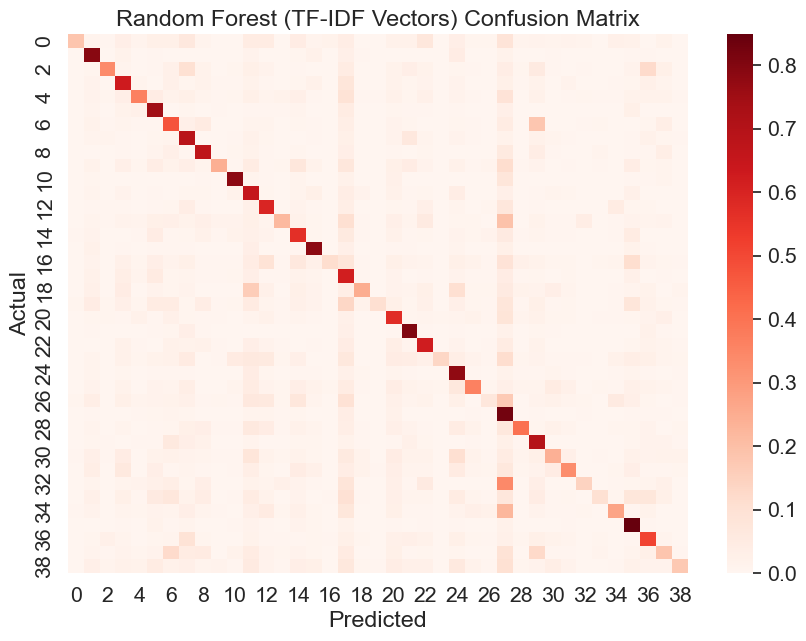

In [26]:
output_metrics(y_tfidf_test, rf_tfidf_predicted, normalize_cm=True, title_cm='Random Forest (TF-IDF Vectors) Confusion Matrix')